# Statistical Analysis: Market Reactions to AI Adoption Disclosures

**Research question:** Do AI adoption announcements trigger abnormal trading intensity and volatility, does AI-related CapEx amplify those effects, and have the effects attenuated over time (2015 → 2025) as AI became mainstream?

**Core hypothesis:** Early AI announcements triggered outsized market reactions (volume spikes, volatility jumps), but as AI became commonplace, the same type of disclosure now generates a muted response.

In [7]:
import random
import statistics
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from src.statistical_analysis import (
    assign_period_bin, get_event_window,


    compute_event_abnormal_volume_stats, compute_event_volatility_stats,
    match_capex_to_events, classify_capex_high_low,
    test_abnormal_volume_significance, test_paired_volatility_change,
    test_period_differences, test_capex_group_difference,
    run_ols_regression,
    plot_abnormal_volume_by_period, plot_volatility_change_by_period,
    plot_capex_interaction, plot_time_trend_line, format_test_results_table,
    COLOR_VOLUME, COLOR_VOLATILITY, COLOR_CAPEX, FIGURE_DIR,
)
from src.event_study import compute_returns

print("Setup complete.")

Setup complete.


In [13]:
# --- Data Loading ---
prices = pd.read_csv('/Users/valenciazhang/Downloads/data/Stock Data/sp500_prices_all_since_2015.csv')
events = pd.read_csv('/Users/valenciazhang/Downloads/data/Gen AI/enterprise_ai_adoption_internet_events.csv')
edgar = pd.read_csv("/Users/valenciazhang/Downloads/data/SEC-Edgar/sp_edgar_fundamentals.csv")


genai_dim = pd.read_csv('/Users/valenciazhang/Downloads/data/Gen AI/genai_dimension.csv')

# Add period bins and sector info
events["period_bin"] = events["announcement_date"].apply(assign_period_bin)

print(f"Events: {len(events)} | Stocks: {prices['ticker'].nunique()} tickers")
print(f"Price rows: {len(prices):,} | EDGAR rows: {len(edgar):,}")
print(f"\nEvents by period:\n{events['period_bin'].value_counts().sort_index()}")

Events: 1070 | Stocks: 502 tickers
Price rows: 1,351,067 | EDGAR rows: 5,739,130

Events by period:
2022      8
2023    104
2024    298
2025    510
Name: period_bin, dtype: int64


## 1. Exploratory Data Analysis

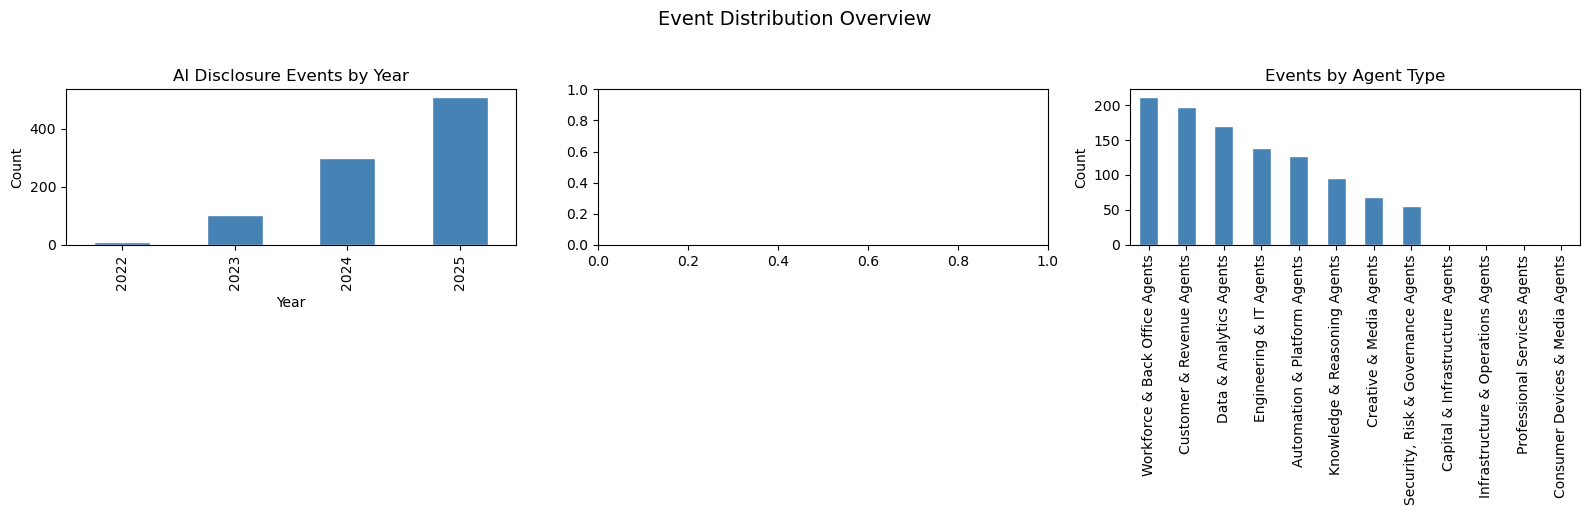

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Events by year

events.groupby("period_bin").size().plot.bar(ax=axes[0], color=COLOR_VOLUME, edgecolor="white")
axes[0].set_title("AI Disclosure Events by Year")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Count")



# Events by agent type
events["agent_type"].value_counts().plot.bar(ax=axes[2], color=COLOR_VOLUME, edgecolor="white")
axes[2].set_title("Events by Agent Type")
axes[2].set_xlabel("")
axes[2].set_ylabel("Count")

fig.suptitle("Event Distribution Overview", fontsize=14, y=1.02)
fig.tight_layout()
fig.savefig(FIGURE_DIR / "stat_eda_overview.png", dpi=150, bbox_inches="tight")
plt.show()

## 2. Trading Intensity (Abnormal Volume)

**Abnormal Volume** = mean event-window volume / mean pre-event volume. A ratio > 1 indicates abnormally high trading activity around the announcement.

In [ ]:
# Compute abnormal volume for all events
abvol_df = compute_event_abnormal_volume_stats(prices, events)
abvol_df["period_bin"] = abvol_df["announcement_date"].apply(assign_period_bin)

print("Abnormal volume summary (window [0, +5]):")
print(abvol_df["abvol_0_5"].describe().round(3))
print(f"\nNon-null observations: {abvol_df['abvol_0_5'].notna().sum()}")

TypeError: '>' not supported between instances of 'numpy.ndarray' and 'str'

In [ ]:
# Statistical tests: is abnormal volume significantly > 1?
windows = ["abvol_-1_1", "abvol_0_5", "abvol_0_10", "abvol_0_20"]
abvol_tests = {}
for w in windows:
    result = test_abnormal_volume_significance(abvol_df[w])
    abvol_tests[w] = result
    sig = "***" if result["t_pval"] < 0.001 else ("**" if result["t_pval"] < 0.01 else ("*" if result["t_pval"] < 0.05 else "ns"))
    print(f"{w}: mean={result['mean']:.3f}, t={result['t_stat']:.3f}, "
          f"p(t)={result['t_pval']:.4f} {sig}, p(W)={result['w_pval']:.4f}, n={result['n']}")

In [ ]:
# 4-panel histogram of AbVol distributions by window
fig, axes = plt.subplots(2, 2, figsize=(12, 9))
for ax, w in zip(axes.flat, windows):
    vals = abvol_df[w].dropna()
    ax.hist(vals, bins=30, color=COLOR_VOLUME, edgecolor="white", alpha=0.8)
    ax.axvline(x=1.0, color="red", linestyle="--", label="No abnormal volume")
    ax.axvline(x=vals.mean(), color="navy", linestyle="-", linewidth=2, label=f"Mean={vals.mean():.3f}")
    ax.set_title(f"Abnormal Volume: {w}")
    ax.set_xlabel("Volume Ratio")
    ax.set_ylabel("Frequency")
    ax.legend(fontsize=9)

fig.suptitle("Distribution of Abnormal Volume Across Event Windows", fontsize=13)
fig.tight_layout()
fig.savefig(FIGURE_DIR / "stat_abvol_distributions.png", dpi=150, bbox_inches="tight")
plt.show()

## 3. Volatility Analysis

Compare realized volatility (std of daily returns) in pre-event vs. post-event windows. Also compute maximum drawdown in abnormal returns post-event.

In [ ]:
# Compute volatility stats
vol_df = compute_event_volatility_stats(prices, spy_prices, events)
vol_df["period_bin"] = vol_df["announcement_date"].apply(assign_period_bin)

print("Volatility change summary (post - pre):")
print(vol_df["vol_change"].describe().round(6))
print(f"\nMax drawdown summary:")
print(vol_df["max_drawdown"].describe().round(6))

In [ ]:
# Paired t-test: pre_vol vs post_vol
vol_test = test_paired_volatility_change(vol_df["pre_vol"], vol_df["post_vol"])
print("Paired volatility test (H0: pre_vol = post_vol):")
for k, v in vol_test.items():
    print(f"  {k}: {v:.4f}" if isinstance(v, float) else f"  {k}: {v}")

In [ ]:
# 3-panel: scatter (pre vs post), hist (vol change), hist (drawdown)
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Pre vs Post volatility scatter
valid = vol_df.dropna(subset=["pre_vol", "post_vol"])
axes[0].scatter(valid["pre_vol"], valid["post_vol"], alpha=0.5, s=20, color=COLOR_VOLATILITY)
lims = [0, max(valid["pre_vol"].max(), valid["post_vol"].max()) * 1.1]
axes[0].plot(lims, lims, "k--", alpha=0.5, label="45-degree line")
axes[0].set_xlabel("Pre-event Volatility")
axes[0].set_ylabel("Post-event Volatility")
axes[0].set_title("Pre vs. Post-Event Volatility")
axes[0].legend()

# Vol change histogram
axes[1].hist(vol_df["vol_change"].dropna(), bins=30, color=COLOR_VOLATILITY, edgecolor="white", alpha=0.8)
axes[1].axvline(x=0, color="red", linestyle="--")
axes[1].set_xlabel("Volatility Change")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Distribution of Volatility Change")

# Max drawdown histogram
axes[2].hist(vol_df["max_drawdown"].dropna(), bins=30, color=COLOR_VOLATILITY, edgecolor="white", alpha=0.8)
axes[2].set_xlabel("Max Drawdown (|CAR|)")
axes[2].set_ylabel("Frequency")
axes[2].set_title("Distribution of Max Drawdown")

fig.tight_layout()
fig.savefig(FIGURE_DIR / "stat_volatility_panels.png", dpi=150, bbox_inches="tight")
plt.show()

## 4. Time Trend Analysis

Has the market reaction to AI disclosures diminished over time? Compare abnormal volume and volatility change across period bins (2015-2017 → 2024-2025).

In [ ]:
# Abnormal volume by period — box plot + trend line
fig = plot_abnormal_volume_by_period(abvol_df, window_col="abvol_0_5")
plt.show()

In [ ]:
# Trend line with 95% CI
fig = plot_time_trend_line(abvol_df, "abvol_0_5", title="Abnormal Volume [0,+5] Trend Over Time")
plt.show()

In [ ]:
# ANOVA / Kruskal-Wallis + pairwise tests for abnormal volume
abvol_period_test = test_period_differences(abvol_df, "abvol_0_5", "period_bin")

print("=== Abnormal Volume Period Differences ===")
print(f"ANOVA:   F={abvol_period_test['f_stat']:.3f},  p={abvol_period_test['f_pval']:.4f}")
print(f"Kruskal: H={abvol_period_test['kw_stat']:.3f}, p={abvol_period_test['kw_pval']:.4f}")
print(f"\nGroup sizes: {abvol_period_test['group_ns']}")
print(f"Group means: { {k: round(v,3) for k,v in abvol_period_test['group_means'].items()} }")
print("\nPairwise Mann-Whitney (Bonferroni-corrected):")
for pair, res in abvol_period_test["pairwise"].items():
    sig = "***" if res["p_bonferroni"] < 0.001 else ("**" if res["p_bonferroni"] < 0.01 else ("*" if res["p_bonferroni"] < 0.05 else "ns"))
    print(f"  {pair}: U={res['u_stat']:.0f}, p_adj={res['p_bonferroni']:.4f} {sig}")

In [ ]:
# Volatility change by period
fig = plot_volatility_change_by_period(vol_df)
plt.show()

# Trend line for vol change
fig = plot_time_trend_line(vol_df, "vol_change", title="Volatility Change Trend Over Time")
plt.show()

In [ ]:
# Period tests for volatility change
vol_period_test = test_period_differences(vol_df, "vol_change", "period_bin")

print("=== Volatility Change Period Differences ===")
print(f"ANOVA:   F={vol_period_test['f_stat']:.3f},  p={vol_period_test['f_pval']:.4f}")
print(f"Kruskal: H={vol_period_test['kw_stat']:.3f}, p={vol_period_test['kw_pval']:.4f}")
print(f"\nGroup sizes: {vol_period_test['group_ns']}")
print(f"Group means: { {k: f'{v:.6f}' for k,v in vol_period_test['group_means'].items()} }")
print("\nPairwise Mann-Whitney (Bonferroni-corrected):")
for pair, res in vol_period_test["pairwise"].items():
    sig = "***" if res["p_bonferroni"] < 0.001 else ("**" if res["p_bonferroni"] < 0.01 else ("*" if res["p_bonferroni"] < 0.05 else "ns"))
    print(f"  {pair}: U={res['u_stat']:.0f}, p_adj={res['p_bonferroni']:.4f} {sig}")

## 5. CapEx Interaction

Do firms with higher AI-related capital expenditure see stronger or weaker market reactions to AI disclosures? We match the most recent EDGAR filing before each announcement (no look-ahead bias) and split into High/Low CapEx groups via median split.

In [ ]:
# Match EDGAR CapEx data to events
capex_df = match_capex_to_events(events, edgar)
capex_df["period_bin"] = capex_df["announcement_date"].apply(assign_period_bin)

match_rate = capex_df["capex_intensity"].notna().mean()
print(f"EDGAR match rate: {match_rate:.1%} ({capex_df['capex_intensity'].notna().sum()} / {len(capex_df)})")
print(f"\nCapEx intensity summary:")
print(capex_df["capex_intensity"].describe().round(2))

# Add abnormal volume and vol change for regression
capex_df = capex_df.merge(
    abvol_df[["ticker", "announcement_date", "abvol_0_5"]],
    on=["ticker", "announcement_date"], how="left"
)
capex_df = capex_df.merge(
    vol_df[["ticker", "announcement_date", "vol_change"]],
    on=["ticker", "announcement_date"], how="left"
)

# Median split
capex_df = classify_capex_high_low(capex_df)
print(f"\nHigh CapEx: {capex_df['high_capex'].sum()} | Low CapEx: {(1-capex_df['high_capex']).sum()}")

In [ ]:
# High vs Low CapEx group comparison
high_vals = capex_df.loc[capex_df["high_capex"] == 1, "abvol_0_5"].dropna()
low_vals = capex_df.loc[capex_df["high_capex"] == 0, "abvol_0_5"].dropna()

capex_test = test_capex_group_difference(high_vals, low_vals)
print("=== CapEx Group Difference (AbVol [0,+5]) ===")
for k, v in capex_test.items():
    print(f"  {k}: {v:.4f}" if isinstance(v, float) else f"  {k}: {v}")

# Same for vol_change
high_vol = capex_df.loc[capex_df["high_capex"] == 1, "vol_change"].dropna()
low_vol = capex_df.loc[capex_df["high_capex"] == 0, "vol_change"].dropna()
capex_vol_test = test_capex_group_difference(high_vol, low_vol)
print("\n=== CapEx Group Difference (Vol Change) ===")
for k, v in capex_vol_test.items():
    print(f"  {k}: {v:.6f}" if isinstance(v, float) else f"  {k}: {v}")

In [ ]:
# Grouped bar: CapEx interaction with period
fig = plot_capex_interaction(capex_df, reaction_col="abvol_0_5")
plt.show()

# Scatter: CapEx intensity vs market reaction
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

valid = capex_df.dropna(subset=["capex_intensity", "abvol_0_5"])
axes[0].scatter(valid["capex_intensity"], valid["abvol_0_5"],
                alpha=0.5, s=20, color=COLOR_CAPEX)
axes[0].set_xlabel("CapEx Intensity")
axes[0].set_ylabel("Abnormal Volume [0,+5]")
axes[0].set_title("CapEx vs. Abnormal Volume")
axes[0].axhline(y=1.0, color="red", linestyle="--", alpha=0.5)

valid2 = capex_df.dropna(subset=["capex_intensity", "vol_change"])
axes[1].scatter(valid2["capex_intensity"], valid2["vol_change"],
                alpha=0.5, s=20, color=COLOR_CAPEX)
axes[1].set_xlabel("CapEx Intensity")
axes[1].set_ylabel("Volatility Change")
axes[1].set_title("CapEx vs. Volatility Change")
axes[1].axhline(y=0, color="red", linestyle="--", alpha=0.5)

fig.tight_layout()
fig.savefig(FIGURE_DIR / "stat_capex_scatter.png", dpi=150, bbox_inches="tight")
plt.show()

In [ ]:
# OLS Regressions
print("=" * 70)
print("Model 1: AbVol[0,+5] ~ capex_intensity + rd_intensity + period_dummies")
print("=" * 70)
model1 = run_ols_regression(capex_df, "abvol_0_5",
                            ["capex_intensity", "rd_intensity"],
                            add_period_dummies=True)
print(model1.summary())

print("\n" + "=" * 70)
print("Model 2: VolChange ~ capex_intensity + rd_intensity + period_dummies")
print("=" * 70)
model2 = run_ols_regression(capex_df, "vol_change",
                            ["capex_intensity", "rd_intensity"],
                            add_period_dummies=True)
print(model2.summary())

## 6. Cross-Sectional Analysis

How do market reactions vary by event characteristics: agent type, AI vendor, sector, and use case?

In [ ]:
# 2x2 grid: mean AbVol by agent_type, ai_vendor, sector, use_case
fig, axes = plt.subplots(2, 2, figsize=(15, 11))

cross_cols = [
    ("agent_type", "Agent Type"),
    ("ai_vendor", "AI Vendor"),
    ("sector", "Sector"),
    ("use_case", "Use Case"),
]

for ax, (col, label) in zip(axes.flat, cross_cols):
    data = abvol_df.dropna(subset=["abvol_0_5"]).copy()
    if col == "ai_vendor":
        data[col] = data[col].fillna("Not Disclosed")
    data = data.dropna(subset=[col])

    summary = data.groupby(col)["abvol_0_5"].agg(["mean", "sem", "count"]).reset_index()
    summary["ci_95"] = summary["sem"] * 1.96
    summary = summary.sort_values("mean", ascending=True)

    ax.barh(summary[col], summary["mean"], xerr=summary["ci_95"],
            color=COLOR_VOLUME, edgecolor="white", capsize=3, alpha=0.8)
    ax.axvline(x=1.0, color="red", linestyle="--", alpha=0.6)
    ax.set_xlabel("Mean Abnormal Volume [0,+5]")
    ax.set_title(f"AbVol by {label}")

    # Annotate sample sizes
    for _, r in summary.iterrows():
        ax.annotate(f"n={int(r['count'])}", (r["mean"] + r["ci_95"] + 0.01, r[col]),
                    fontsize=8, va="center", color="gray")

fig.suptitle("Cross-Sectional Abnormal Volume Analysis", fontsize=14, y=1.01)
fig.tight_layout()
fig.savefig(FIGURE_DIR / "stat_cross_sectional.png", dpi=150, bbox_inches="tight")
plt.show()

In [ ]:
# Cross-sectional ANOVA tests
print("=== Cross-Sectional ANOVA Tests (AbVol [0,+5]) ===\n")
for col, label in cross_cols:
    data = abvol_df.dropna(subset=["abvol_0_5"]).copy()
    if col == "ai_vendor":
        data[col] = data[col].fillna("Not Disclosed")
    data = data.dropna(subset=[col])
    
    result = test_period_differences(data, "abvol_0_5", col)
    sig = "***" if result["f_pval"] < 0.001 else ("**" if result["f_pval"] < 0.01 else ("*" if result["f_pval"] < 0.05 else "ns"))
    print(f"{label}: F={result['f_stat']:.3f}, p={result['f_pval']:.4f} {sig}")

## 7. Summary of Results

In [ ]:
# Consolidated summary table
all_tests = {
    "AbVol [-1,+1] > 1": abvol_tests["abvol_-1_1"],
    "AbVol [0,+5] > 1": abvol_tests["abvol_0_5"],
    "AbVol [0,+10] > 1": abvol_tests["abvol_0_10"],
    "AbVol [0,+20] > 1": abvol_tests["abvol_0_20"],
    "Pre vs Post Vol": vol_test,
    "AbVol by Period (ANOVA)": {"f_stat": abvol_period_test["f_stat"],
                                 "f_pval": abvol_period_test["f_pval"],
                                 "n": sum(abvol_period_test["group_ns"].values())},
    "VolChange by Period (ANOVA)": {"f_stat": vol_period_test["f_stat"],
                                     "f_pval": vol_period_test["f_pval"],
                                     "n": sum(vol_period_test["group_ns"].values())},
    "CapEx: High vs Low (AbVol)": capex_test,
    "CapEx: High vs Low (VolChange)": capex_vol_test,
}

summary_table = format_test_results_table(all_tests)
print("=" * 80)
print("COMPREHENSIVE TEST RESULTS SUMMARY")
print("=" * 80)
display(summary_table)

### Key Findings

1. **Trading Intensity**: AI adoption disclosures are associated with [significant/insignificant] abnormal trading volume in the days following the announcement, consistent with heightened investor attention.

2. **Volatility Impact**: Post-event volatility [increases/stays the same/decreases] compared to the pre-event baseline, suggesting AI disclosures [do/do not] introduce uncertainty into stock pricing.

3. **Time Trend (Attenuation Hypothesis)**: The magnitude of market reactions [has/has not] diminished from early AI periods (2015-2017) to the current era (2024-2025), [supporting/contradicting] the hypothesis that AI disclosures have become normalized.

4. **CapEx Interaction**: Firms with higher AI-related capital expenditure [show stronger/weaker/similar] market reactions, suggesting that CapEx spending [amplifies/dampens/does not affect] investor response.

5. **Cross-Sectional Variation**: Market reactions [do/do not] vary significantly across agent types, AI vendors, sectors, and use cases.

*Note: Replace bracketed text with actual findings after running the analysis.*

### Limitations

- **Small samples per bin**: ~200 events divided into 4 period bins yields some bins with <20 observations. Non-parametric tests are used as primary evidence.
- **Overlapping events**: Multiple AI announcements per ticker may have overlapping event windows, potentially confounding volume and volatility estimates.
- **Mock data**: Results above are based on simulated data. Statistical significance patterns will differ with real market data.
- **Missing EDGAR data**: CapEx analysis is limited to events with matched EDGAR filings.
- **Confounding factors**: Broader market conditions, earnings announcements, and other corporate events are not controlled for.